In [1]:
using JuMP, Gurobi, Random, CSV, DataFrames, Statistics, JLD2, FileIO
include("scripts/display.jl")
include("scripts/model.jl");
include("scripts/run.jl");

# Map 1

### Inputs

In [2]:
const dr_speed = 5 # nb of minutes per km when driving;
const wk_speed = 12 # nb of minutes per km when walking;

# Map & ts-network parameters
map_title= "vbs_U20_cust_U10"
hubs_ind=[6,7];
nb_locs=15; # Index of sink=nb_locs+1;
vbs_ind=1:nb_locs;
nb_cust=8; 
cust_ind=1:nb_cust;
horizon = 200									
tstep = 10;	

# Model Inputs
nb_veh=2;
G = 0.8 # max driving detour ratio for customers (if W=2: driving time must be inferior to 2*gamma["driving"])
Gtype= "shortestpathpercent" # or "absolutetime"
Wk = 40 # max walking time for customers from origin or to destination
Q= 8 # vehicle capacity;
depot_locs = [rand(1:nb_locs) for i in 1:nb_veh]

datafolder="data/"*map_title*"/";
map_inputs = (datafolder,hubs_ind,vbs_ind,nb_locs,cust_ind,nb_cust,horizon,tstep)
model_inputs = (G,Gtype,Wk,nb_veh,Q,depot_locs);

### Display map & create network

In [3]:
map, tsnetwork, params, cust, vbs, arcs, wo, wd, abbrev,shortest_time = create_network(map_inputs, model_inputs);
q, t, I, K=abbrev;

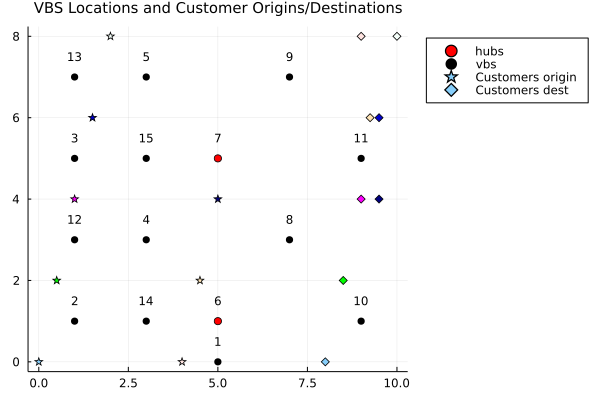

Cust 1, load 1 - Pick-up vbs: [2, 12, 14], Drop-off vbs: [1, 6, 8, 10], 	 depart at: 0.0, arrival before: 140.0
Cust 2, load 1 - Pick-up vbs: [2, 3, 4, 12, 14], Drop-off vbs: [8, 10, 11], 	 depart at: 5.0, arrival before: 130.0
Cust 3, load 1 - Pick-up vbs: [2, 3, 4, 12, 13, 15], Drop-off vbs: [8, 10, 11], 	 depart at: 10.0, arrival before: 130.0
Cust 4, load 1 - Pick-up vbs: [3, 5, 12, 13, 15], Drop-off vbs: [9, 11], 	 depart at: 15.0, arrival before: 140.0
Cust 5, load 1 - Pick-up vbs: [3, 5, 13, 15], Drop-off vbs: [9, 11], 	 depart at: 20.0, arrival before: 160.0
Cust 6, load 1 - Pick-up vbs: [1, 2, 4, 6, 14], Drop-off vbs: [9, 11], 	 depart at: 0.0, arrival before: 150.0
Cust 7, load 1 - Pick-up vbs: [1, 4, 6, 7, 8, 14], Drop-off vbs: [9, 11], 	 depart at: 5.0, arrival before: 120.0
Cust 8, load 1 - Pick-up vbs: [4, 6, 7, 8, 15], Drop-off vbs: [8, 10, 11], 	 depart at: 10.0, arrival before: 100.0


In [4]:
# Show map
display(map)
for i in I
    load= q[i]
    println("Cust $i, load $load - Pick-up vbs: ", params.vo[i], ", Drop-off vbs: ", params.vd[i], ", \t depart at: ", round(t[i],digits=1), ", arrival before: ", params.deadlines[i])
end

In [5]:
# Print number of nodes and arcs
if false
    println("Initialized time space network with...")
    println("Num nodes (total) = ", tsnetwork.numnodes)
    println("Num arcs (total) = ", tsnetwork.numarcs);
    for i in I
        println("Num arcs for Cust $i = ", length(params.Ai[i]))
    end
end

In [6]:
# To visualize some arcs
if false
    timespaceviz_arcs("viz.png", horizon, tstep, tsnetwork, params.Ai[5], x_size=2000, y_size=1000)
end

### Model & Results

Best obj: 707, Root relaxation obj 654 ==> 7.5% gap

In [7]:
# Model objective coefficients
mu=1 # coefficient in front of walking time
beta=1 # coefficient in front of waiting time
lambda=1 # transfer penalty
alpha1=0.01 # coefficient in front of vehicle driving time and utilization 
nu=1 # coefficient in front of vehicle utilization
alpha2=0 # coefficient in front of unmet demand
coefficients=mu,beta,lambda,alpha1,nu,alpha2;

In [8]:
xi,x,z,obj,solvetime,objs=network_model_v2(Q,abbrev,wo,tsnetwork,params,coefficients,1);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 496381 rows, 200147 columns and 1262464 nonzeros
Model fingerprint: 0xa2466d58
Variable types: 0 continuous, 200147 integer (200147 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 329330 rows and 96894 columns (presolve time = 41s) ...
Presolve removed 361967 rows and 116089 columns
Presolve time: 41.16s
Presolved: 134414 rows, 84058 columns, 498645 nonzeros
Variable types: 0 continuous, 84058 integer (84058 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    

In [20]:
save_res = true; # to save the results in the result folder
resultfolder="results/"*map_title*"/";

In [12]:
if save_res
    if !isdir(resultfolder)
        mkdir(resultfolder)
    end
    jldsave(resultfolder*"K"*string(nb_veh)*"_nlocs"*string(nb_locs)*"_ncust"*string(nb_cust)*"_Q"*string(Q)*"_Wk"*string(Wk)*".jld2", xi=xi, x=x, z=z)
end

#### Results

In [17]:
xi,x,z=load(resultfolder*"K"*string(nb_veh)*"_nlocs"*string(nb_locs)*"_ncust"*string(nb_cust)*"_Q"*string(Q)*"_Wk"*string(Wk)*".jld2", "xi", "x", "z");

KPIs

In [18]:
display_KPIs(xi,x,z,tsnetwork,params,I,K,q,wo,t,false)


 Customer KPIs:
Mean #transfers: 0.0
Mean waiting time: 7.0
Mean walking time: 50.0
Mean travel time: 33.0
Mean efficiency: 0.73

 Vehicle KPIs:
# vehicles used: 2.0
Mean distance: 14.0
Mean capacity: 1.05
Mean service time: 69.0
Mean carrying time: 43.0


### Visualizations

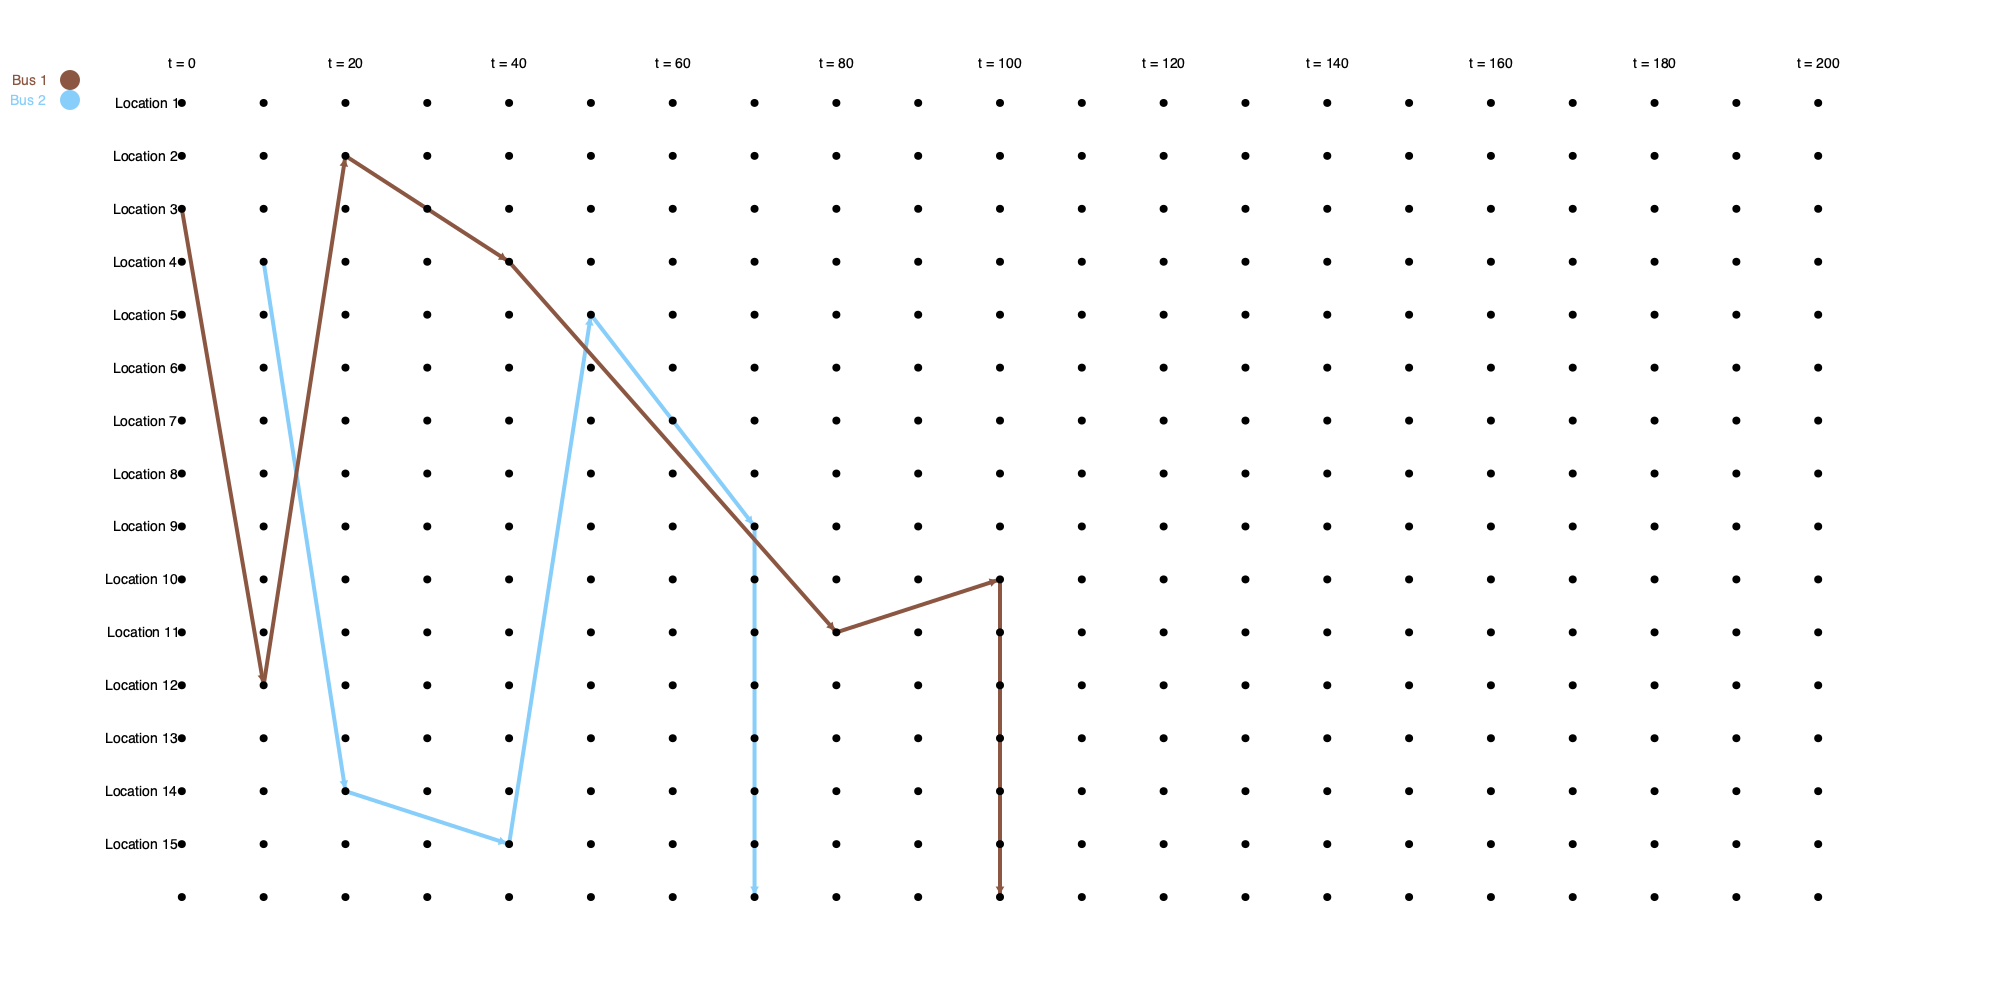

In [ ]:
arcdict=Dict()
for k in K
    # list of arcs traveled by vehicle k
    arcdict[k] = [a for a in params.A if z[k,a]==1]
end
timespaceviz_bus(resultfolder*"viz.png", horizon, tstep, tsnetwork, arcdict, x_size=2000, y_size=1000)

Traveling arcs used:
Bus 1:
	 Time 0: from loc 3 to 12
	 Time 10: from loc 12 to 2
	 Time 20: from loc 2 to 4, with cust [1]
	 Time 40: from loc 4 to 11, with cust [1, 2, 3, 7, 8]
	 Time 80: from loc 11 to 10, with cust [1]
	 Time 100: from loc 10 to 16
Bus 2:
	 Time 10: from loc 4 to 14
	 Time 20: from loc 14 to 15, with cust [6]
	 Time 40: from loc 15 to 5, with cust [6]
	 Time 50: from loc 5 to 9, with cust [4, 5, 6]
	 Time 70: from loc 9 to 16


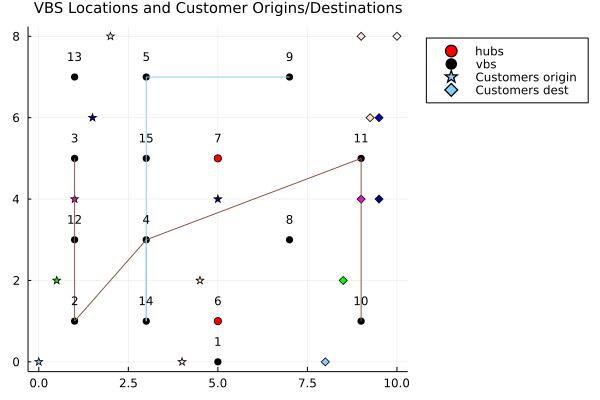

In [ ]:
ts=0 # time from which we want to print the arcs
map2=print_traveling_arcs(z,ts,params.P,params.Ia,K,map,vbs,tsnetwork)